# 第1题

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用黑体（适用于中文）
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
plt.style.use('fivethirtyeight')  # 设置绘图风格

# 随机生成数据
np.random.seed(0)
m, n = 2000, 300
D = np.random.randn(m, n)
y = np.random.randn(m)


In [43]:

# 目标函数
def f(x): return norm(D @ x - y)**2

# 梯度
def grad(x): return 2 * D.T @ (D @ x - y)

# Frank-Wolfe for L1 or Linf
def frank_wolfe(norm_type='l1', max_iter=200):
    x = np.zeros(n)
    fvals = []

    for k in range(1, max_iter + 1):
        g = grad(x)
        if norm_type == 'l1':
            s = np.zeros_like(x)
            idx = np.argmax(np.abs(g))
            s[idx] = -np.sign(g[idx])
        elif norm_type == 'linf':
            s = -np.sign(g)
        gamma = 2 / (k + 2)
        x = (1 - gamma) * x + gamma * s
        fvals.append(f(x))  
    return fvals

# PGD with projection
def project_onto_l1_ball(x, radius=1.0):    
    u = np.abs(x)
    if np.sum(u) <= radius:
        return x
    sorted_u = np.sort(u)[::-1]
    cssv = np.cumsum(sorted_u)
    rho = np.nonzero(sorted_u * np.arange(1, len(x)+1) > (cssv - radius))[0][-1]
    theta = (cssv[rho] - radius) / (rho + 1)
    return np.sign(x) * np.maximum(u - theta, 0)

def project_onto_linf_ball(x, radius=1.0):
    return np.clip(x, -radius, radius)

def projected_gd(norm_type='l1', max_iter=200, lr=0.001):
    x = np.zeros(n)
    fvals = []
    for _ in range(max_iter):
        x = x - lr * grad(x)
        if norm_type == 'l1':
            x = project_onto_l1_ball(x)
        elif norm_type == 'linf':
            x = project_onto_linf_ball(x)
        fvals.append(f(x))
    return fvals

## $\ell_1$

In [51]:
# 得到 f_star 作为基准
f_l1_star = min(frank_wolfe('l1', 5000)[-1], projected_gd('l1', 5000, 0.0001)[-1])
f_l1_star

In [52]:
# 比较收敛速度
maxiter = 2000
fw_l1 = frank_wolfe('l1', maxiter)
pgd_l1 = projected_gd('l1', maxiter, 0.0001)

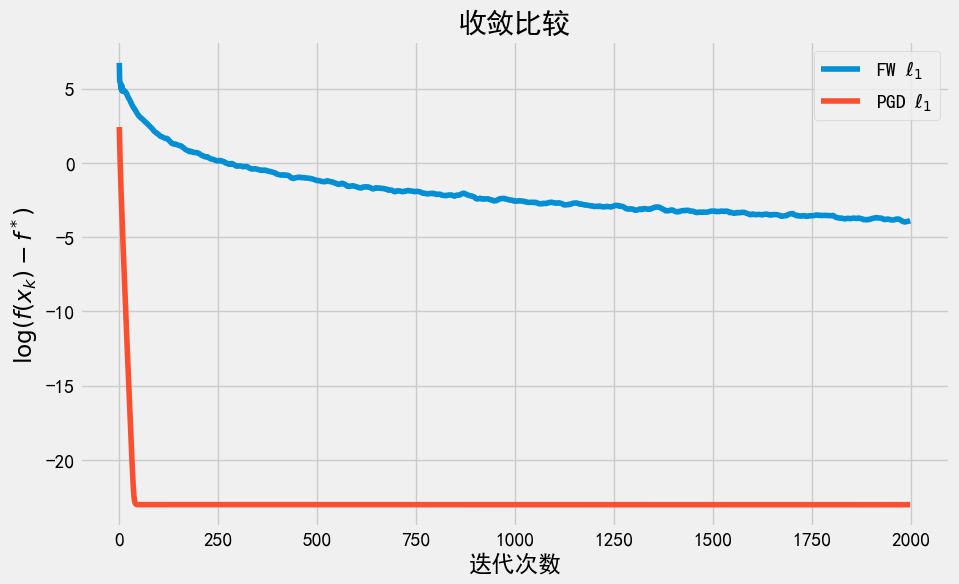

In [65]:
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(np.log(fw_l1 - f_l1_star + 1e-10), label='FW $\\ell_1$')
plt.plot(np.log(pgd_l1 - f_l1_star + 1e-10), label='PGD $\\ell_1$')
plt.xlabel('迭代次数')
plt.ylabel('$\log(f(x_k) - f^*)$')
plt.title('收敛比较')
plt.legend()
plt.show()

## $\ell_\infty$ 

In [62]:
f_linf_star = min(frank_wolfe('linf', 10000)[-1], projected_gd('linf', 10000, 0.0001)[-1])
f_linf_star

1678.0570003715827

In [63]:
fw_linf = frank_wolfe('linf', maxiter)
pgd_linf = projected_gd('linf', maxiter, 0.0001)

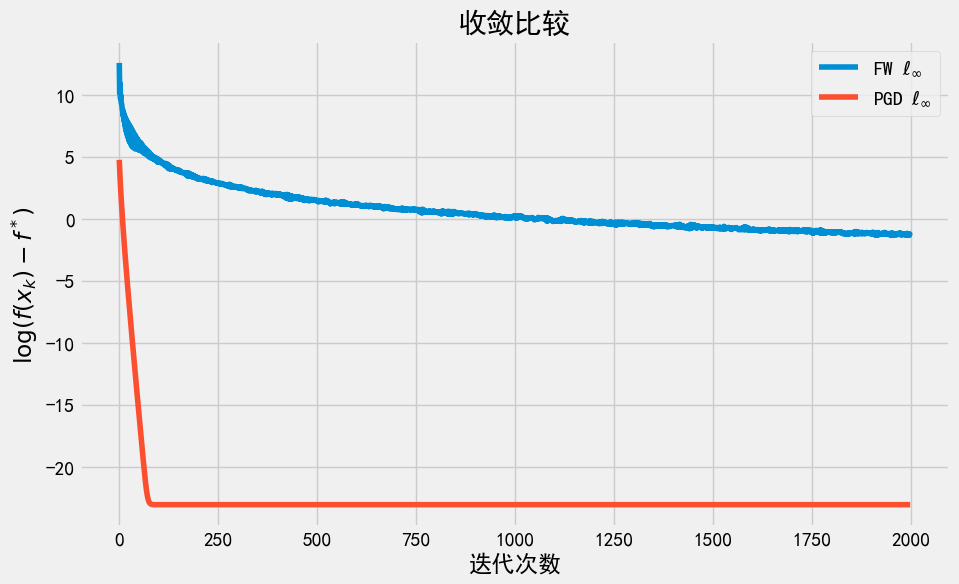

In [64]:
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(np.log(fw_linf - f_linf_star + 1e-10), label='FW $\\ell_\\infty$')
plt.plot(np.log(pgd_linf - f_linf_star + 1e-10), label='PGD $\\ell_\\infty$')
plt.xlabel('迭代次数')
plt.ylabel('$\log(f(x_k) - f^*)$')
plt.title('收敛比较')
plt.legend()
plt.show()

# 第二题

In [102]:
def prox_l1(v, lambd):
    return np.sign(v) * np.maximum(np.abs(v) - lambd, 0)

def dual_ascent(a, b, eta=1, max_iter=600):
    lam = np.zeros_like(a)
    fvals = []
    for _ in range(max_iter):
        x = a - lam * min(1 / np.linalg.norm(lam + 1e-10), 1.0)  # avoid zero division
        y = b - np.clip(lam, -1.0, 1.0)
        lam += eta * (x - y)
        obj = np.linalg.norm(x - a) + np.linalg.norm(x - b, 1)
        fvals.append(obj)
    return fvals

def prox_l2_norm(a, z, gamma):
    diff = z - a
    norm = np.linalg.norm(diff)
    if norm == 0:
        return a
    factor = max(1 - 1 / (gamma * norm), 0)
    return a + factor * diff

def admm(a, b, beta=10, tau=1.0, max_iter=600):
    x, y, u = np.zeros_like(a), np.zeros_like(a), np.zeros_like(a)
    fvals = []
    gamma = tau * beta

    for _ in range(max_iter):
        z = y - u
        x = prox_l2_norm(a, z, gamma)
        y = prox_l1(x + u - b, 1.0 / gamma) + b
        u = u + x - y

        obj = np.linalg.norm(x - a) + np.linalg.norm(x - b, 1)  # 原始目标函数
        fvals.append(obj)
    
    return fvals

In [100]:
a = np.random.randn(100)
b = np.random.randn(100)

In [112]:
f_star = min(admm(a, b, beta=1, tau=0.5, max_iter=3000))  # 近似最优值
f_star

13.484015081235917

## dual secent未能收敛

In [107]:
dual_ascent(a, b, 0.0001, 30000)

[107.01441011976905,
 107.00505708026523,
 106.99570404076135,
 106.98635100125752,
 106.97699796175365,
 106.96764492224979,
 106.95829188274595,
 106.9489388432421,
 106.93958580373824,
 106.93023276423439,
 106.92087972473054,
 106.91152668522668,
 106.90217364572283,
 106.89282060621896,
 106.88346756671511,
 106.87411452721126,
 106.86476148770743,
 106.85540844820358,
 106.84605540869971,
 106.83670236919586,
 106.82734932969198,
 106.81799629018815,
 106.80864325068431,
 106.79929021118042,
 106.78993717167658,
 106.78058413217272,
 106.7712310926689,
 106.76187805316503,
 106.75252501366117,
 106.74317197415733,
 106.73381893465348,
 106.72446589514962,
 106.71511285564577,
 106.70575981614189,
 106.69640677663804,
 106.6870537371342,
 106.67770069763036,
 106.66834765812649,
 106.65899461862264,
 106.64964157911879,
 106.64028853961494,
 106.63093550011108,
 106.62158246060723,
 106.61222942110338,
 106.60287638159951,
 106.5935233420957,
 106.58417030259182,
 106.574817263087

## ADMM

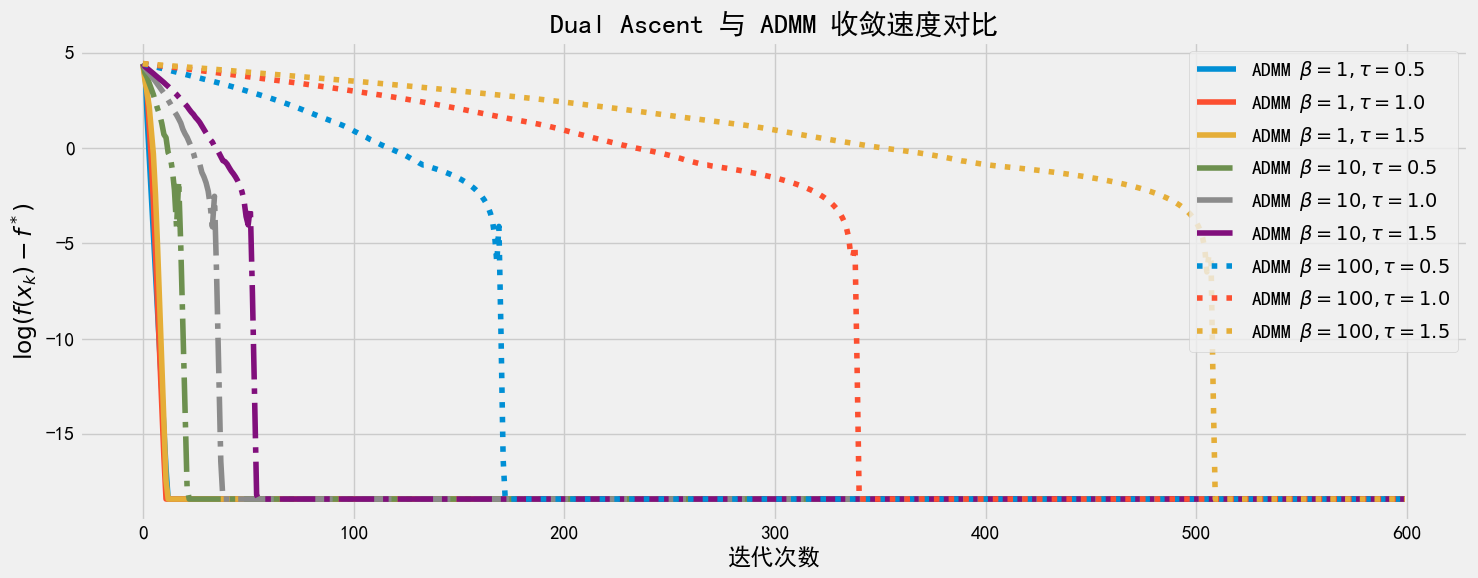

In [113]:
# ADMM 全部组合
betas = [1, 10, 100]
taus = [0.5, 1.0, 1.5]
plt.figure(figsize=(15, 6))
ls = ['-',  '-.', ':']
for i, beta in enumerate(betas):
    for tau in taus:
        admm_hist = admm(a, b, beta=beta, tau=tau)
        admm_log = np.log(np.maximum(np.array(admm_hist) - f_star, 1e-8))
        label = rf"ADMM $\beta={beta}, \tau={tau}$"
        plt.plot(admm_log, label=label, linestyle=ls[i])

# plt.plot(dual_log, label="Dual Ascent", linestyle="--", color="black")
plt.xlabel("迭代次数")
plt.ylabel(r"$\log(f(x_k) - f^*)$")
plt.title("Dual Ascent 与 ADMM 收敛速度对比")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 第三题

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 奇异值软阈值函数（Singular Value Thresholding）
def svt(M, tau):
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    S_threshold = np.maximum(S - tau, 0)
    return U @ np.diag(S_threshold) @ Vt

# l21范数的列缩放操作
def solve_l21(R, lambd_over_beta):
    E = np.zeros_like(R)
    for j in range(R.shape[1]):
        norm = np.linalg.norm(R[:, j])
        if norm > lambd_over_beta:
            E[:, j] = (1 - lambd_over_beta / norm) * R[:, j]
    return E

# 主优化函数
def ladmap_matrix_decomposition(D, lambd=0.01, eps1=1e-6, eps2=1e-5, beta0=None, beta_max=1e10, rho0=1.9, max_iter=5000):
    m, n = D.shape
    Z = np.zeros((n, n))
    E = np.zeros_like(D)
    Y1 = np.zeros_like(D)
    Y2 = np.zeros((n, 1))

    beta = beta0 if beta0 is not None else min(n, m) * eps2
    eta_D = 1.02 * (np.linalg.norm(D, 2) ** 2)

    one = np.ones((n, 1))

    history = {'res_primal': [], 'res_dual': []}

    for k in range(max_iter):
        # 更新Z
        term1 = D.T @ (D @ Z + E - D)
        term2 = one @ ((Z.T @ one - one).T)
        term3 = (1 / beta) * D.T @ Y1
        term4 = (1 / beta) * one @ Y2.T

        G = Z - (1 / eta_D) * (term1 + term2 + term3 + term4)
        Z_new = svt(G, 1 / (eta_D * beta))

        # 更新E
        R = D - D @ Z_new + (1 / beta) * Y1
        E_new = solve_l21(R, lambd / beta)

        # 更新乘子
        Y1 += beta * (D - D @ Z_new - E_new)
        Y2 += beta * (Z_new.T @ one - one)

        # 收敛判断
        res_primal = np.linalg.norm(D - D @ Z_new - E_new) / np.linalg.norm(D)
        res_dual = max(
            np.linalg.norm(Z_new - Z) / np.linalg.norm(D),
            np.linalg.norm(E_new - E) / np.linalg.norm(D)
        )

        history['res_primal'].append(res_primal)
        history['res_dual'].append(res_dual)

        if res_primal < eps1 or res_dual < eps2:
            break

        # 自适应更新 beta
        if beta * max(np.sqrt(eta_D) * np.linalg.norm(Z_new - Z), np.linalg.norm(E_new - E)) / np.linalg.norm(D) < eps2:
            beta = min(rho0 * beta, beta_max)

        Z, E = Z_new, E_new

    return Z, E, history

In [24]:
# 生成示例数据
np.random.seed(0)
m, n = 50, 40
Z_true = np.random.randn(n, n)
D = np.random.randn(m, n) @ Z_true
D += 0.1 * np.random.randn(*D.shape)  # 添加噪声

# 执行算法
Z_est, E_est, hist = ladmap_matrix_decomposition(D)

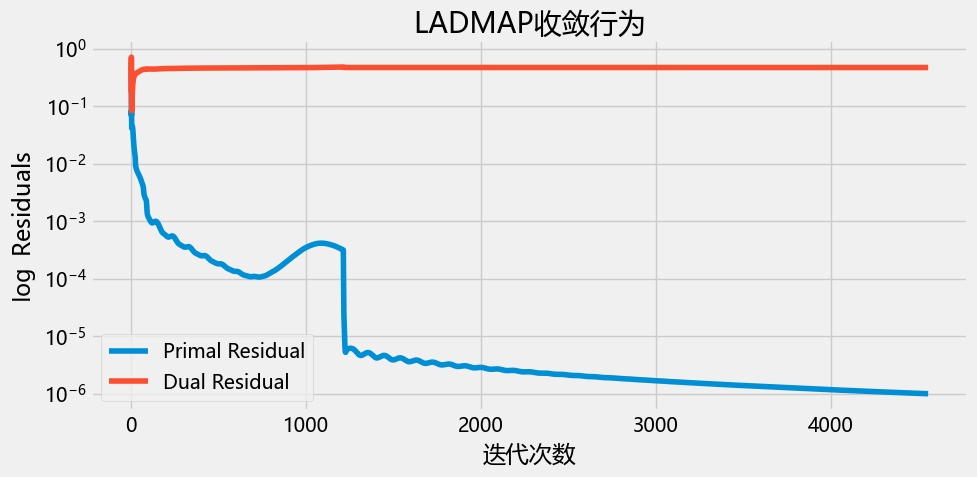

In [25]:

# 可视化收敛过程
plt.figure(figsize=(10, 5))
plt.semilogy(hist['res_primal'], label='Primal Residual')
plt.semilogy(hist['res_dual'], label='Dual Residual')
plt.xlabel('迭代次数')
plt.ylabel(r'$\log$ Residuals')
plt.title('LADMAP收敛行为')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
